데이터셋 다운로드
http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

위 링크가 안 될 경우 여기서 online retail.xlsx 클릭
http://archive.ics.uci.edu/ml/machine-learning-databases/00352/


In [ ]:
# 구글 코랩일 경우 실행  
from google.colab import drive
drive.mount('/content/drive') 
userpath='/content/drive/MyDrive/CUAI' # 이 부분 본인 경로로 바꾸기 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 7-6. 군집화 실습 - 고객 세그먼테이션 (Customer Segmentation)

### 고객 세그먼테이션의 정의와 기법

* 다양한 기준으로 고객을 분류하는 기법. CRM이나 마켓팅의 중요 기반 요소
* 주요 목표: 타겟 마케팅(고객을 여러 특성에 맞게 세분화하여 그 유형에 따라 맞춤형 마케팅이나 서비스를 제공)
* 고객의 어떤 요소를 기반으로 군집화할 것인가를 결정하는 것이 중요. 교재에선 기본적인 분석 요소인 RFM 기법을 이용함
  * Recency: 가장 최근 상품 구입일에서 오늘까지의 기간
  * Frequency: 상품 구매 횟수
  * Monetary value: 총 구매 금액

**목표**

온라인 판매 데이터를 기반으로 고객 세그먼테이션을 클러스터링 기반으로 수행.

### 데이터 셋 로딩과 데이터 클린징

In [ ]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel(io=userpath+'/Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


* InvoiceNo: 주문번호, C로 시작하는 주문은 취소 주문
* StockCode: 제품 코드
* Description: 제품 설명
* Quantity: 주문 제품 건수
* InvoiceDate: 주문 일자
* UnitPrice: 제품 단가
* CustomerID: 고객 번호
* Country: 주문 고객의 국적

In [ ]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


6번 열의 null값이 너무 많음(13만 5천 건 정도)... 다른 열도 오류 데이터가 존재함. → 사전 정제 작업 필요

* **null data 제거**: 고객 식별 번호가 없는 건 필요가 없으므로 삭제
* **오류 데이터 삭제**: Quantity 또는 UnitPrice가 0보다 작은 것들..인데 사실 quantity가 0보다 작은 건 반품을 뜻하는 값으로, InvoiceNo 앞에 C가 있을 거임. 분석의 효율성을 위해 얘네는 다 삭제 갈기겠음

In [ ]:
# 필터링
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
retail_df['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

영국만 한바가지임... 영국을 제외한 나라는 싹다 삭제 갈기겠음.

In [ ]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


### RFM 기반 데이터 가공

정제된 데이터로 고객 세그먼테이션 군집화를 RFM 기반으로 수행해보겠음. 그러기 위해 가공을 해줘야 함
* UnitPrice와 Quantity를 곱해서 주문 금액 데이터를 만들 거임
* CustomerNo를 int형으로 바꿔주겠음 (float형이었음)

In [ ]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

<ipython-input-9-879155f23e07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
<ipython-input-9-879155f23e07>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)


이 데이터 세트는 주문 횟수와 주문 금액이 압도적으로 특정 고객에게 몰려있음. 왜냐면 개인 고객과 소매점 주문이 섞여 있기 때문임.

In [ ]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


특정 몇 명이 압도적으로 많은 것을 확인 가능... (첫 번째 출력에선 상위 3명, 두 번째 출력에서도 상위 3명이 압도적)

주문번호+상품코드로 Group by를 수행하면 거의 1에 가깝게 유일한 식별자 레벨이 됨

In [ ]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

주문번호+상품코드 기준의 데이터를 고객 기준의 RFM 데이터로 변경하겠음. 이를 위해 주문번호 기준의 데이터를 개별 고객 기준의 데이터로 Group by를 해야 함.

In [ ]:
# DataFrame의 groupby() 의 multiple 연산을 위해 agg() 이용
# agg()에 parameter로 대사 ㅇ칼럼들과 aggregation 함수명들을 딕셔너리 형태로 입력하면 칼럼 여러 개의 서로 다른 aggregation 연산을 쉽게 수행할 수 있음 
# Recency는 InvoiceDate 컬럼의 max() 에서 데이터 가공
# Frequency는 InvoiceNo 컬럼의 count() , Monetary value는 sale_amount 컬럼의 sum()
aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'sale_amount':'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations) # CustomerID 기준으로 DataFrame 새롭게 생성
# groupby된 결과 컬럼값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


In [ ]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency'] #온라인 데이터가 2011년 12월 9일까지의 데이터이므로 '오늘 날짜'는 2011년 12월 10일로 설정하겠음. 
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 컬럼 건수는 ',cust_df.shape)
cust_df.head(3)

cust_df 로우와 컬럼 건수는  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


### RFM 기반 고객 세그먼테이션

이 데이터 세트는 소매업자랑 개인 고객 주문을 전부 포함하고 있어서 매우 왜곡된 데이터 분포도를 가짐. 일단 왜곡된 분포도를 가진 상태에서 클러스터링을 수행하면 어떻게 되는지를 보겠음.

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

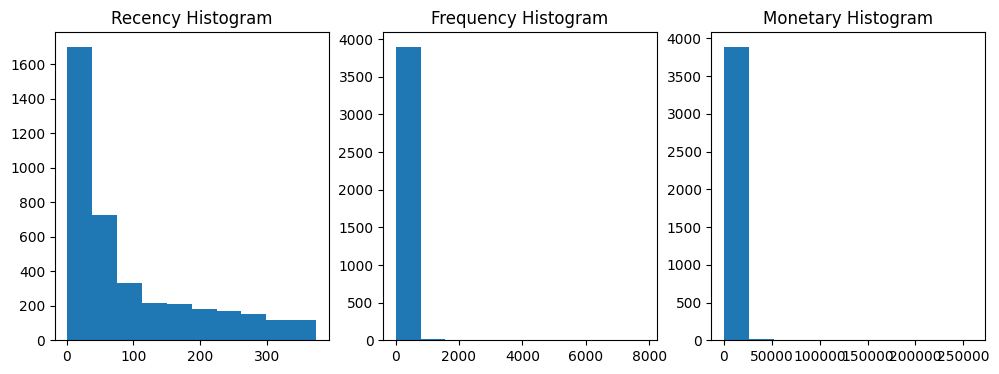

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

F, M이 특히 개 극단적으로 생겨먹음..
백분위로 확인해보자.

In [ ]:
cust_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


R는 평균이 02.7이지만 50%에 해당하는 51보다 크게 높음. max 값은 374로 75%인 143보다 훨씬 커서 왜곡 정도가 높음을 알 수 있음. 다른 애들도 심함


왜곡 정도가 매우 높은 데이터 세트에 K-mean clustering을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행됨.

데이터셋을 StandardScaler로 평균과 표준편차를 재조정한 뒤에 K-mean을 수행해보겠음.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는 : 0.592


0.592면 안정적인 수치.

하지만 각 군집별 실루엣 계수 값은 어떨까? 2절에서 쓴 함수 다시 가져와서 군집 계수를 2~5개까지 변화시키며 개별 군집의 실루엣 계수 값과 데이터 구성을 알아보겠음.

In [ ]:
def visualize_silhouette(cluster_lists, X_features): 
    ### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수###
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [ ]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    ### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화하는 함수 ###
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

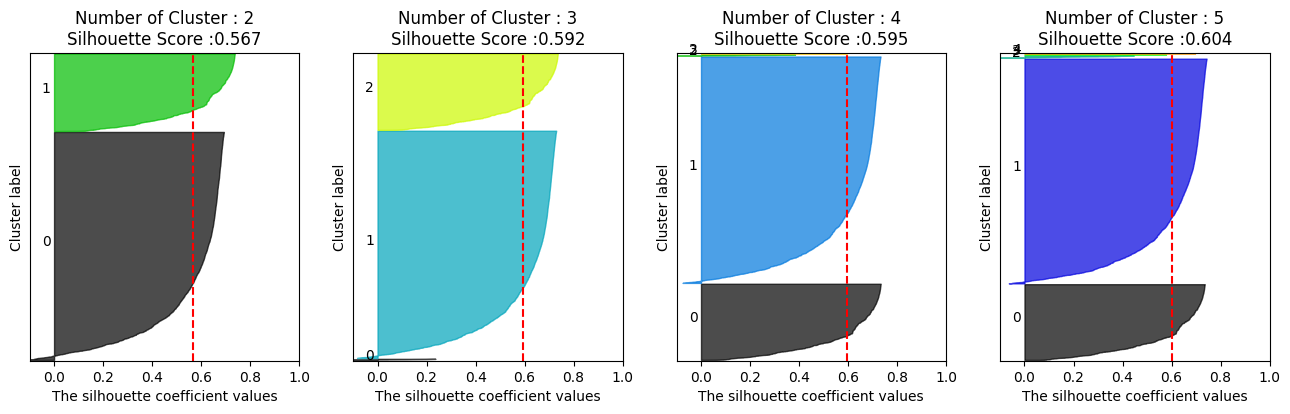

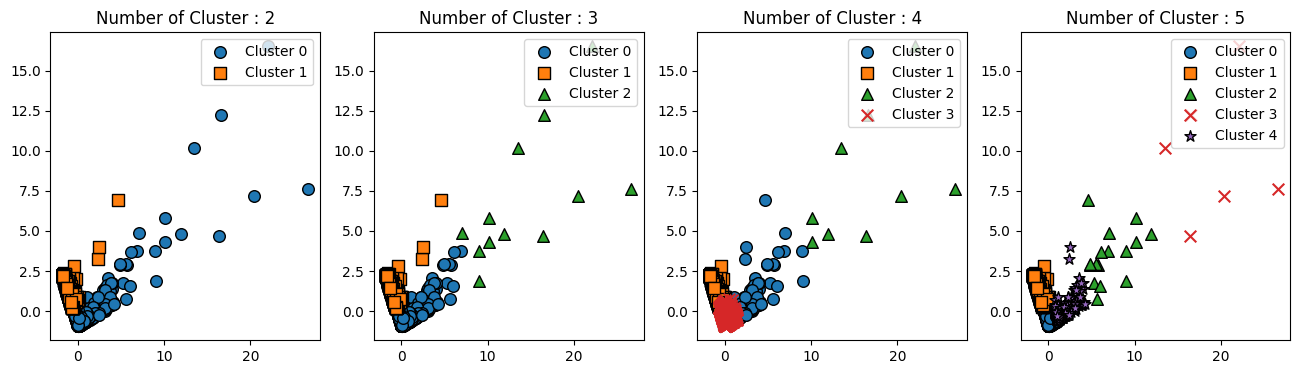

In [ ]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

* 군집 2개: 0번 군집과 1번 군집이 너무 개괄적으로 군집화됨
* 군집 3개: 0번 군집의 데이터 건수가 매우 작음
* 군집 4개: 2, 3번 군집 데이터 개수가 너무 적음
* 군집 5개: 2, 3, 4번 군집에 속한 데이터셋의 개수가 너무 적고 광범위하게 퍼져 있음. 

⇒ 데이터 값이 거리 기반으로 광범위하게 퍼져 있어서 군집 수를 계속 늘려봐야 이 군집만 지속적으로 분리하게 되기에 의미 없는 군집화 결과로 이어짐.

* 지나치게 왜곡된 데이터 세트는 K-mean과 같은 거리 기반 군집화 알고리즘에서 지나치게 일반적인 군집화 결과를 도출
* 비지도학습 알고리즘의 하나인 군집화의 기능적 의미는 숨어 있는 새로운 집단을 발견하는 것이므로, 이 경우 왜곡 정도를 낮춰야 함.
* 대표적으로 Log 변환을 사용

In [ ]:
### Log 변환을 통해 데이터 변환
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequecny, Monetary 컬럼에 np.log1p() 로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는 : 0.303


실루엣 스코어는 떨어졌지만 이 절대치가 중요한 것이 아님에 유의하며 계속 해보자.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

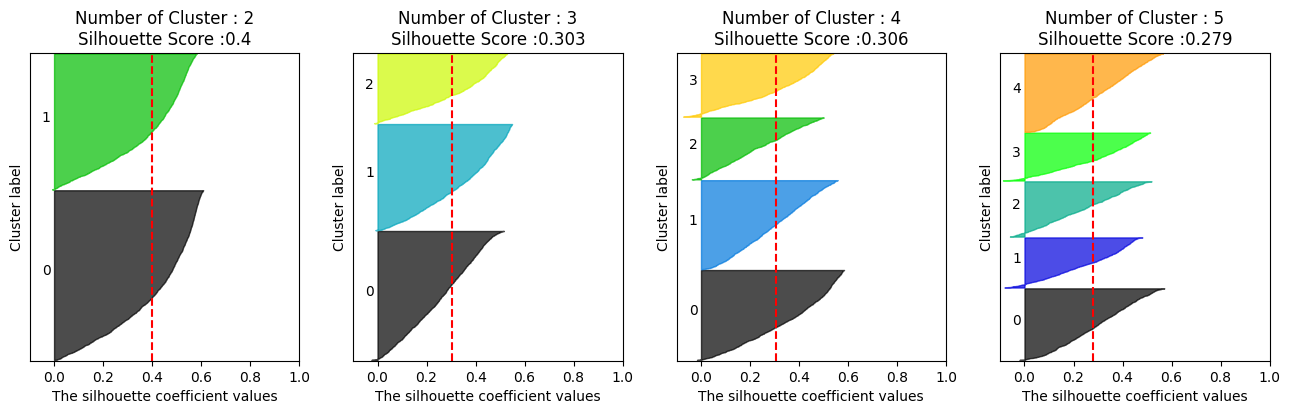

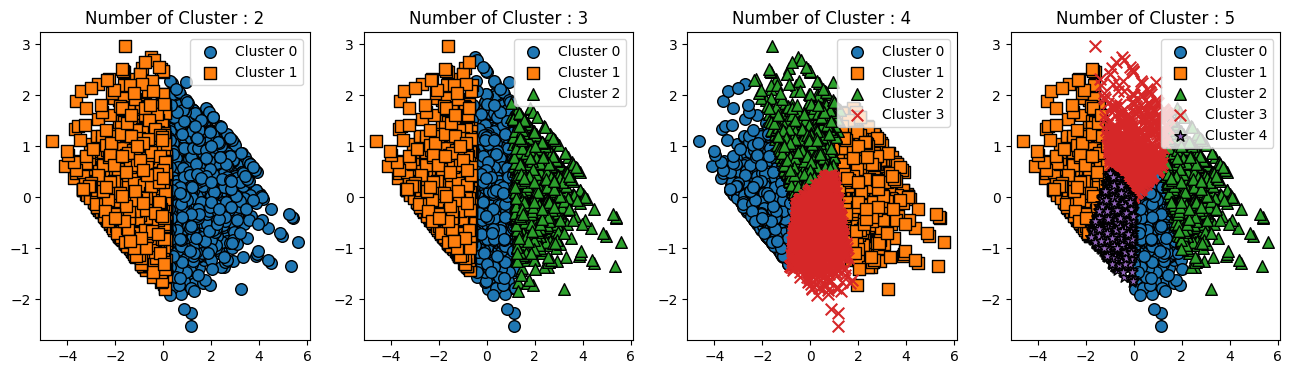

In [ ]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

훨씬 균일하게 군집화가 됐다.

⇒ **왜곡된 데이터 세트에 대해서는 로그 변환으로 데이터를 일차 변환한 후에 군집화를 수행하면 더 나은 결과를 도출할 수 있음!**

# 7-7. 정리

* **K-mean**
  * 거리 기반으로 군집 중심점을 이동시키면서 군집화 수행
  * 매우 쉽고 직관적인 알고리즘
  * 복잡한 구조를 가지는 데이터 세트에 적용하기엔 한계가 있음
  * 군집의 개수를 최적화하기 어려움
  * 평가: 실루엣 계수 이용
* Mean Shift
  * K-mean과 유사 / 거리 중심이 아닌 데이터가 모여 있는 밀도가 가장 높은 쪽으로 군집 중심점을 이동시키면서 군집화 수행
  * CV 영역에서 이미지나 영상 데이터의 특정 개체를 구분하거나 움직임을 추적하는 데에 뛰어난 역할을 수행하는 알고리즘
* GMM(Gaussian Mixture Model)
  * 데이터가 여러 개의 가우시안 분포(Gaussian Distribution)를 섞어서 생성된 모델로 가정해 수행
  * 다른 정규 분포를 가진 데이터 세트를 각각 군집화
  * K-mean보다 유연하게 다양한 데이터 세트에 잘 적용될 수 있음
  * 군집화를 위한 수행 시간이 오래 걸림
* DBSCAN (Density Based Spatial Clustering of Applications with Noise)
  * 밀도 기반 군집화의 대표적인 알고리즘
  * 입실론 주변 영역 내에 포함되는 최소 데이터 개수의 충족 여부에 따라 데이터 포인트를 다음과 같이 구분함
    * 핵심 포인트
    * 이웃 포인트
    * 경계 포인트
    * 잡음 포인트
  * 특정 핵심 포인트에서 직접 접근이 가능한 다른 핵심 포인트를 서로 연결하면서 군집화를 구성하는 방식
  * 간단하고 직관적인 알고리즘
  * 데이터 분포가 기하학적으로 복잡한 데이터 세트에도 효과적